## 1.1 视觉工具包：torchvision
计算机视觉是深度学习中最重要的一类应用，为了方便研究者使用，PyTorch团队专门开发了一个视觉工具包`torchvion`，这个包独立于PyTorch，需通过`pip instal torchvision`安装。torchvision主要包含三部分：

- models：提供深度学习中各种经典网络的网络结构以及预训练好的模型，包括`AlexNet`、VGG系列、ResNet系列、Inception系列等。
- datasets： 提供常用的数据集加载，设计上都是继承`torhc.utils.data.Dataset`，主要包括`MNIST`、`CIFAR10/100`、`ImageNet`、`COCO`等。
- transforms：提供常用的数据预处理操作，主要包括对Tensor以及PIL Image对象的操作

In [1]:
from torchvision import models
from torch import nn

# 加载预训练模型，如果不存在会进行下载
# 预训练好的模型保存在 ~/.cache/torch/checkpoints/
resnet34 = models.squeezenet1_1(pretrained=True, num_classes=1000)
resnet34.fc = nn.Linear(512, 10)

In [2]:
# 数据集不存在则下载至指定路径， train=False获取测试集
from torchvision import datasets
dataset = datasets.MNIST('data/', download=True, train=False)

Transforms    
涵盖了大部分对Tensor和PIL Image的常用处理，还可将多个处理操作用Compose拼接起来，形成一个处理转换流程。下文详细介绍。需要注意的是转换分为两步：   
- 第一步：构建转换操作，例如`transf = transforms.Normalize(mean=x, std=y)`    
- 第二步：执行转换操作，例如`output = transf(input)`

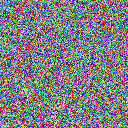

In [3]:
import torch as t
from torchvision import transforms

to_pil = transforms.ToPILImage()
to_pil(t.randn(3, 128, 128))

常用函数：
- make_grid: 多张图片拼接成网格
- save_img: 将tensor保存成图片

In [4]:
len(dataset)

10000

In [5]:
make_grid??

Object `make_grid` not found.


In [6]:
# 代码运行有问题，后续解决
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms as F
from torchvision.utils import make_grid, save_image

dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0], nrow=4)

to_img = T.ToPILImage()
to_img(img)

TypeError: batch must contain tensors, numbers, dicts or lists; found <class 'PIL.Image.Image'>

## 1.2 数据处理    
数据的处理对训练神经网络来说十分重要，良好的数据处理不仅会加速模型训练，更会提高模型效果。    
PyTorch提供了几个高效便捷的工具，以便使用者进行数据处理或增强等操作，同时可通过并行化加速数据加载。

### 1.2.1 数据加载/自定义数据集    
pytorch中可通过自定义的数据集对象进行数据的加载。数据集对象被抽象为`Dataset`类，实现自定义的数据集需要继承Dataset，并实现两个Python魔法方法：
- `__getitem__`：返回一条数据，或一个样本。`obj[index]`等价于`obj.__getitem__(index)`
- `__len__`：返回样本的数量。`len(obj)`等价于`obj.__len__()`

In [2]:
import os
import numpy as np
import torch as t
from torch.utils import data
from PIL import Image

In [3]:
# "Dogs vs. Cats"是一个经典二分类问题，其所有图片都存放在一个文件夹下，根据文件名的前缀判断是狗还是猫
class DogvsCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        # 这里只指定绝对路径，没有实际加载，只有调用__getitem__时才会读图
        self.imgs = [os.path.join(root, img) for img in imgs]
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        
        pil_image = Image.open(img_path)
        array = np.array(pil_image)
        data = t.from_numpy(array)
        
        return data, label
    
    def __len__(self):
        return len(self.imgs)

In [4]:
dataset = DogvsCat('./data/dogcat/')

# 相当于调用dataset.__getitem__(0)
img, label = dataset[0]
for img,label in dataset:
    print(img.size(), label)

torch.Size([499, 379, 3]) 0
torch.Size([236, 289, 3]) 0
torch.Size([375, 499, 3]) 1
torch.Size([400, 300, 3]) 1
torch.Size([500, 497, 3]) 0
torch.Size([374, 499, 3]) 0
torch.Size([377, 499, 3]) 1
torch.Size([375, 499, 3]) 1


自定义自己的数据集，虽然可以依次获取。但返回的数据不适合实际使用，因其具有如下两方面问题：
- 返回样本的形状不一，因每张图片的大小不一样，这对于需要取batch训练的神经网络来说很不友好
- 返回样本的数值较大，未归一化至[-1, 1]

### 1.2.2 transforms    
为了解决上述问题，`torchvision`提供了许多视觉图像处理工具，其中`transforms`模块提供了对PIL `Image`对象和`Tensor`对象的常用操作    
（1）对PIL Image的操作包括：
- `Scale`：调整图片尺寸，长宽比保持不变
- `CenterCrop`、`RandomCrop`、`RandomResizedCrop`： 裁剪图片
- `Pad`：填充
- `ToTensor`：将PIL Image对象转成Tensor，会自动将[0, 255]归一化至[0, 1]

（2）对Tensor的操作包括：
- Normalize：标准化，即减均值，除以标准差
- ToPILImage：将Tensor转为PIL Image对象             
  
**Compose函数：**    
如果要对图片进行多个操作，可通过`Compose`函数将这些操作拼接起来，类似于`nn.Sequential`。     
注意：这些操作定义后是以函数的形式存在，真正使用时需调用它的`__call__`方法，这点类似于`nn.Module`。    
例如要将图片调整为$224\times 224$，首先应构建这个操作`trans = Resize((224, 224))`，然后调用`trans(img)`。

In [1]:
import os
from PIL import  Image
import numpy as np
from torchvision import transforms as T

In [11]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) 
])

class DogCat(data.Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        
        pil_img = Image.open(img_path)
        if self.transforms:
            data = self.transforms(pil_img)
        
        return data, label
    
    def __len__(self):
        return len(self.imgs)
    
dataset = DogCat('./data/dogcat/', transforms=transform)
img, label = dataset[0]
for img, label in dataset:
    print(img.size(), label)

torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1


除上述操作，transforms还可通过`Lambda`封装自定义的转换策略     
例如想对PIL Image进行随机旋转，则可写成这样`trans=T.Lambda(lambda img: img.rotate(random()*360))`

### 1.2.3 ImageFolder      
torchvision已经预先实现了常用的Dataset, `ImageFolder`是经常使用的一个Dataset——`ImageFolder`。`ImageFolder`假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名，其构造函数如下：
```
ImageFolder(root, transform=None, target_transform=None, loader=default_loader)
```
- `root`：在root指定的路径下寻找图片
- `transform`：对PIL Image进行的转换操作，transform的输入是使用loader读取图片的返回对象
- `target_transform`：对label的转换
- `loader`：给定路径后如何读取图片，默认读取为RGB格式的PIL Image对象

label是按照文件夹名顺序排序后存成字典，即{类名:类序号(从0开始)}     
一般来说最好直接将文件夹命名为从0开始的数字，这样会和ImageFolder实际的label一致，如果不是这种命名规范，建议看看`self.class_to_idx`属性以了解label和文件夹名的映射关系

In [13]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('./data/dogcat_2/')
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [15]:
# 所有图片路径及对应label
dataset.imgs

[('./data/dogcat_2/cat/cat.12484.jpg', 0),
 ('./data/dogcat_2/cat/cat.12485.jpg', 0),
 ('./data/dogcat_2/cat/cat.12486.jpg', 0),
 ('./data/dogcat_2/cat/cat.12487.jpg', 0),
 ('./data/dogcat_2/dog/dog.12496.jpg', 1),
 ('./data/dogcat_2/dog/dog.12497.jpg', 1),
 ('./data/dogcat_2/dog/dog.12498.jpg', 1),
 ('./data/dogcat_2/dog/dog.12499.jpg', 1)]

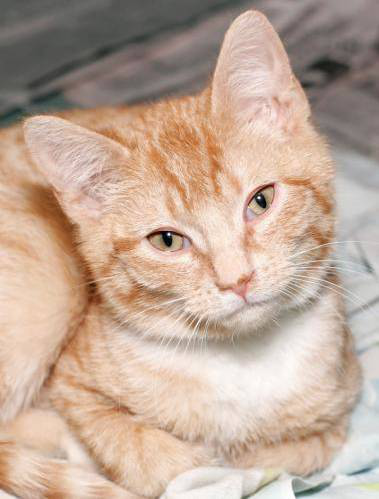

In [17]:
# 第一维是第几张图，第二维为1返回label,为0返回图片数据
dataset[1][0]

In [18]:
dataset[1][1]

0

In [19]:
normalize = T.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

torch.Size([3, 224, 224])


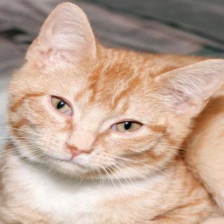

In [20]:
dataset = ImageFolder('./data/dogcat_2/', transform=transform)
print(dataset[1][0].size())

pil_img = T.ToPILImage()
pil_img(dataset[1][0]*0.2 + 0.4)

### 1.2.4 Dataloader       
`Dataset`只负责数据的抽象，一次调用`__getitem__`只返回一个样本。我们希望在训练神经网络时，最好是对一个batch的数据进行操作，同时还需要对数据进行shuffle和并行加速等。对此，PyTorch提供了`DataLoader`帮助我们实现这些功能    
`DataLoader`函数定义如下：     
```
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=<function default_collate at 0x7f8f22700950>,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
)
```    

- dataset：加载的数据集(Dataset对象)
- batch_size：batch size
- shuffle:：是否将数据打乱
- sampler： 样本抽样，后续会详细介绍
- num_workers：使用多进程加载的进程数，0代表不使用多进程
- collate_fn： 如何将多个样本数据拼接成一个batch，一般使用默认的拼接方式即可
- pin_memory：是否将数据保存在pin memory区，pin memory中的数据转到GPU会快一些
- drop_last：dataset中的数据个数可能不是batch_size的整数倍，drop_last为True会将多出来不足一个batch的数据丢弃

In [23]:
from torch.utils.data import DataLoader
#DataLoader??

In [26]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, drop_last=False)

dataiter = iter(dataloader)
imgs, label = next(dataiter)
# batch_size, channel, height, weight
imgs.size()

torch.Size([4, 3, 224, 224])

dataloader是一个可迭代的对象，意味着我们可以像使用迭代器一样使用它，例如：
```python
for batch_datas, batch_labels in dataloader:
    train()
```
或
```
dataiter = iter(dataloader)
batch_datas, batch_labesl = next(dataiter)
```

#### 自定义`collate_fn`    
在数据处理中，有时会出现某个样本无法读取等问题，比如某张图片损坏。这时在`__getitem__`函数中将出现异常，此时最好的解决方案即是将出错的样本剔除。     

如果实在是遇到这种情况无法处理，则可以返回None对象，然后在`Dataloader`中实现自定义的`collate_fn`，将空对象过滤掉。但要注意，在这种情况下dataloader返回的batch数目会少于batch_size

In [32]:
class NewDogCat(DogCat):
    def __getitem__(self, index):        
        try:
            # 调用父类的获取函数，即 DogCat.__getitem__(self, index)
            return super(NewDogCat, self).__getitem__(index)
        except:
            return None, None
        
import torch as t    
from torch.utils.data.dataloader import default_collate

def my_collate_fn(batch):
    batch = list(filter(lambda x:x[0] is not None, batch))
    if len(batch) == 0:
        return t.Tensor()
    return default_collate(batch)        

In [33]:
dataset = NewDogCat('./data/dogcat_wrong/', transforms=transform)
dataset[5]

(tensor([[[ 1.3333,  1.3333,  1.3529,  ..., -1.4706, -1.5490, -1.5490],
          [ 1.3137,  1.3333,  1.3333,  ..., -1.4706, -1.5098, -1.5098],
          [ 1.3529,  1.3725,  1.3725,  ..., -1.5098, -1.5490, -1.5294],
          ...,
          [ 1.1176,  1.1373,  1.1373,  ...,  1.4902,  1.5490,  1.5490],
          [ 1.1176,  1.0980,  1.1176,  ...,  1.5490,  1.5882,  1.5490],
          [ 1.0980,  1.0784,  1.0784,  ...,  1.5686,  1.6078,  1.5294]],
 
         [[ 1.4314,  1.4314,  1.4510,  ..., -1.5686, -1.6471, -1.6471],
          [ 1.4118,  1.4314,  1.4510,  ..., -1.5686, -1.6078, -1.6078],
          [ 1.4510,  1.4706,  1.4902,  ..., -1.6078, -1.6471, -1.6275],
          ...,
          [ 0.2745,  0.3529,  0.3725,  ...,  0.6078,  0.6667,  0.6863],
          [ 0.3137,  0.3137,  0.3137,  ...,  0.6275,  0.6667,  0.6667],
          [ 0.3137,  0.2745,  0.2549,  ...,  0.5882,  0.6275,  0.6078]],
 
         [[ 1.3333,  1.3137,  1.2941,  ..., -1.6667, -1.7255, -1.7255],
          [ 1.3137,  1.2941,

In [34]:
dataloader = DataLoader(dataset, 2, collate_fn=my_collate_fn, num_workers=1,shuffle=True)

for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(),batch_labels.size())

torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])


batch_size为1通过指定`drop_last=True`来丢弃最后一个不足batch_size的batch